In [1]:
# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import SIEMENSLONGBOTTLE, PIQTSP
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import (
    series_number, acquisition_number, coil_elements,
    qa_date, scanner_operator, larmor_frequency,
    tales_reference_power, transmitter_calibration,
    gradient_sensitivities, software_versions
)
# -- Watermark ---
wm = watermark()
display(
    pd.DataFrame(
        {'Watermark': list(wm.values())},
        index=wm.keys())
)

Watermark
CalculationTime  2022-04-27T14:18:47+01:00
User                        birchhub/rtrhd
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.12
dcmextras                            0.3.0
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

### Details of series to Analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid

series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series)[0]
scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')
display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner              AWP183105
Date                  20220422
Patient  AQA20220522NBTCOSSOLA
Study         4875dfd6-7a84-49

# Summary
Tests performed:

- Slice shape and profile
- Geometric distortion and linearity
- Resolution
- Ghosting
- Head coil image uniformity
- Head coil SNR

All of the above are acceptable.

----

### Recommended Actions

No actions necessary.

In [3]:
aqadate = (datetime.strptime(date_of_scan, '%Y%m%d') + timedelta(days=365)).strftime('%B %Y')

text = f'''
This machine is next due for Annual QA tests in {aqadate}.
'''
HTMLLatex(text, text)

----

In [4]:
text = f'''
BIRCH
Medical Physics & Bioengineering, UHBW
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

HTMLLatex(
    f'<pre>{text}</pre>',
    '\n'.join([
        r'\vfill',
        '\n',
        r'\begin{verbatim}',
        text,
        r'\end{verbatim}'
    ])
)

In [5]:
NewPage

# Detailed Results
The detailed results for each of the tests run are presented below.

----

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo with a T<sub>E</sub> of 30ms using the PIQT slice profile block.

### 3 mm Slice

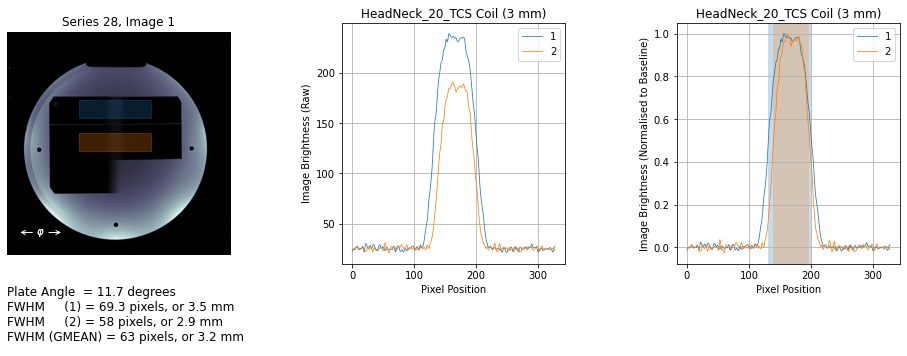

In [6]:
# TO2: Slice 3mm
patid, studyid, series, slices = itemgetter('PatID', 'StudyID', 'Series', 'Slice')(tests['SliceProfile_PIQT'])
series_no, slice_idx = series['3mm'], slices['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobj = fetch_series(patid, studyid, sernos=series_no)[0]
results = slice_profile_report(dobj, frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

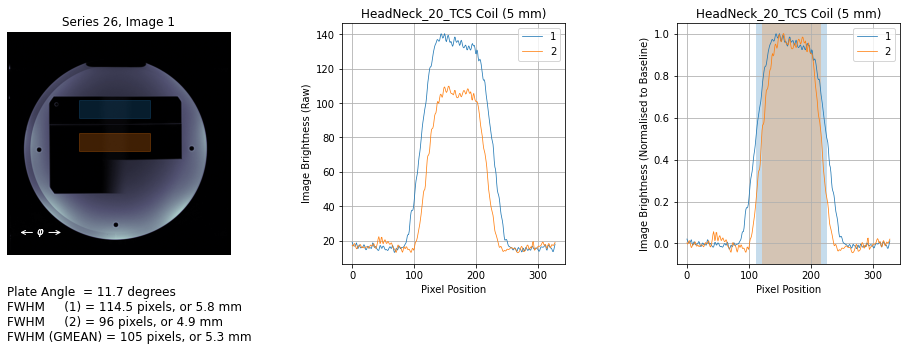

In [7]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
patid, studyid, series, slices = itemgetter('PatID', 'StudyID', 'Series', 'Slice')(tests['SliceProfile_PIQT'])
series_no, slice_idx = series['5mm'], slices['5mm']

dobj = fetch_series(patid, studyid, sernos=series_no)[0]
result = slice_profile_report(dobj, frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [8]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                63.4             3.2
5.0                               105.2             5.3

These are both rather rounded profiles as seen on other Siemens scanners with this protocol. The profile widths, though, are well within the AAPM tolerance of 0.5mm.

In [9]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are *after* applying Siemens 2D distortion correction.

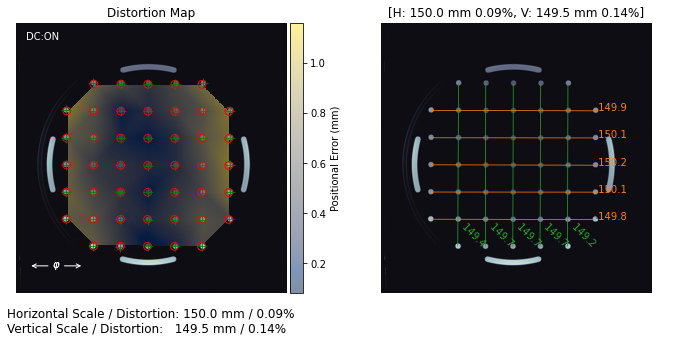

In [10]:
# PIQT: Distortion
patid, studyid, series, slices = itemgetter('PatID', 'StudyID', 'Series', 'Slice')(tests['Distortion_PIQT'])
series_no, slice_idx = series['AxialRL_Corrected'], slices['AxialRL_Corrected']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialRL_Corrected'])[0]
results = piqt_distortion_report(dobj, frame=slices['AxialRL_Corrected'])

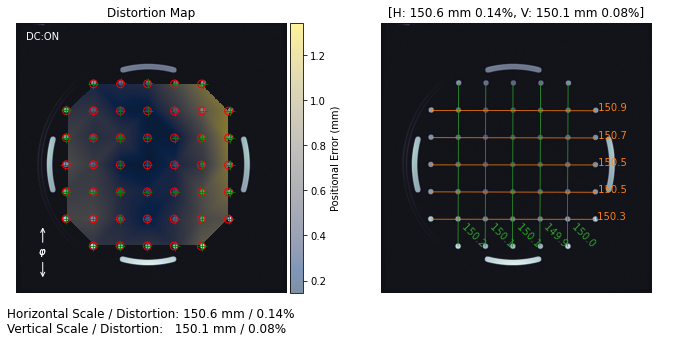

In [11]:
# PIQT: Distortion
# SE: Axial, Phase AP, 512 matrix
patid, studyid, series, slices = itemgetter('PatID', 'StudyID', 'Series', 'Slice')(tests['Distortion_PIQT'])
series_no, slice_idx = series['AxialAP_Corrected'], slices['AxialAP_Corrected']

dobj = fetch_series(patid, studyid, sernos=series_no)[0]
results = results.append(piqt_distortion_report(dobj, frame=slice_idx))

In [12]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion (%)',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion (%)'  
})

Orientation Phase Direction  Horizontal Scale (mm)  \
Series                                                      
28           Axial              RL                150.011   
30           Axial              AP                150.554   

        Horizontal Distortion (%)  Vertical Scale (mm)  \
Series                                                   
28                          0.088              149.527   
30                          0.135              150.056   

        Vertical Distortion (%)  
Series                           
28                        0.135  
30                        0.082

The scale and distortion in both the RL and AP directions are well within 1% at the bandwidth used (130Hz/pixel).

In [13]:
NewPage

## Resolution

Image resolution is estimated by analysis of the MTF block in the PIQT phantom. These results are from an axial slice acquired using a conventional spin echo.

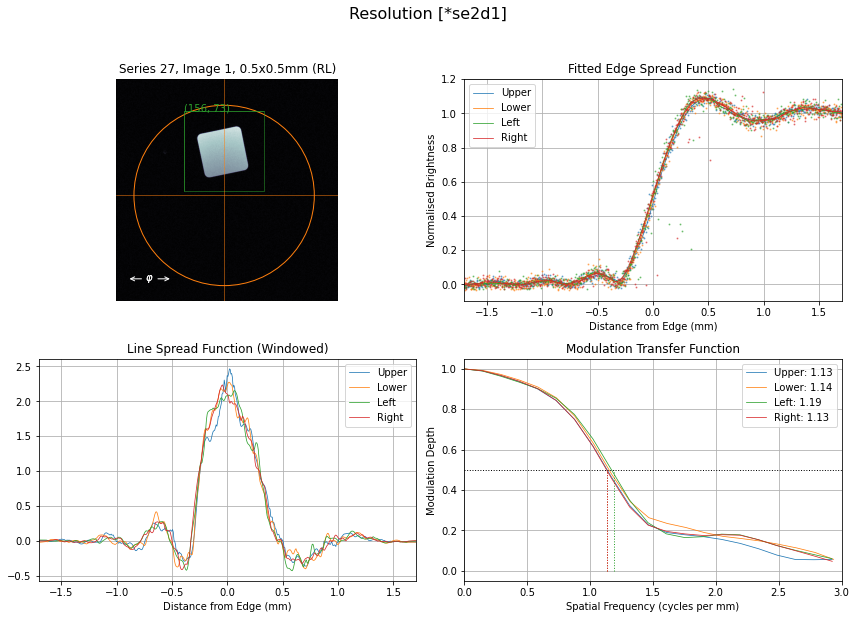

MTF_50
Upper   1.135
Lower   1.139
Left    1.193
Right   1.134

In [14]:
# PIQT: Resoution/MTF
patid, studyid, series, slices = itemgetter('PatID', 'StudyID', 'Series', 'Slice')(tests['Resolution_PIQT'])
series_no, mtf_frame, centring_frame = series['SE512'], slices['MTF'], slices['Centre']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series_no)[0]
results = mtf_report(dobj, mtf_frame=mtf_frame, centring_frame=centring_frame)
plt.show()
results

The MTF_50 is consistent with the nominal image resolution of 0.5 x 0.5 mm (1 cycle per mm).

In [15]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

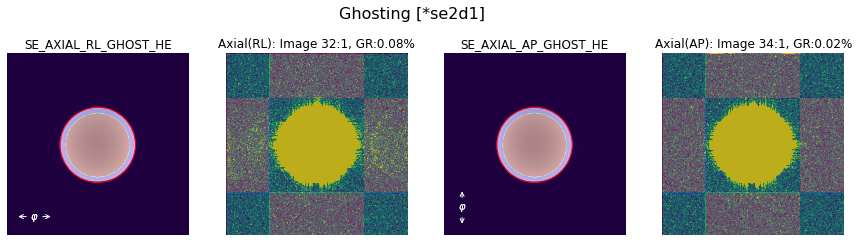

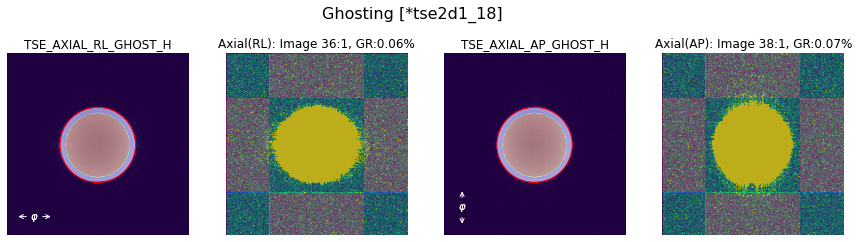

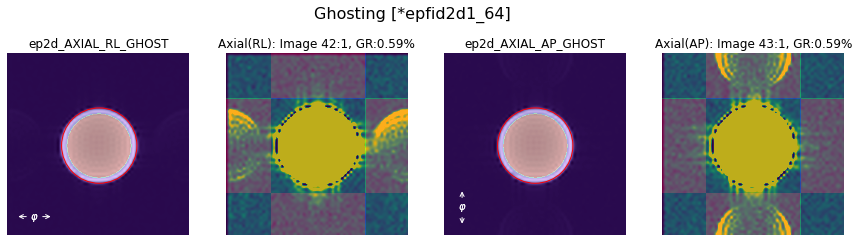

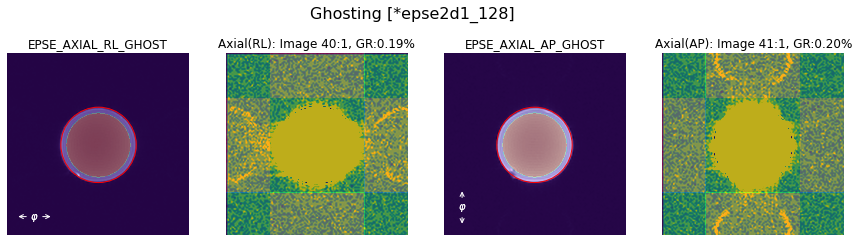

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                           
32            *se2d1       Axial              RL            0.082
34            *se2d1       Axial              AP            0.016
36        *tse2d1_18       Axial              RL            0.063
38        *tse2d1_18       Axial              AP            0.068
42      *epfid2d1_64       Axial              RL            0.593
43      *epfid2d1_64       Axial              AP            0.591
40      *epse2d1_128       Axial              RL            0.190
41      *epse2d1_128       Axial              AP            0.199

In [16]:
# GE10CM: Ghosting
patid, studyid, series = itemgetter('PatID', 'StudyID', 'Series')(tests['Ghosting_GE10'])

# SE Axial
dobjs = [fetch_series(patid, studyid, sernos=[serno])[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, studyid, sernos=[serno])[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, studyid, sernos=[serno])[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, studyid, sernos=[serno])[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is under 1% for all sequences measured here including the EPIs. The most significant ghosting is seen on the GRE EPI (EP_2D/epfid).

In [17]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the standard head/neck coil using a spherical phantom filled with a silicone oil. Results are presented both before and after Siemens `prescan-normalize` intensity correction.

In [18]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
patid, stuid, series = itemgetter('PatID', 'StudyID', 'Series')(tests['Uniformity_Oil'])

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0])
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1])
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0])
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1])
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0])
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

Raw Images


Series No.                                     Protocol  \
Orientation                                                            
Axial                 2  SE_AXIAL_RL_UNIF_HEAD_OIL20CM_PSN_20CH-1819   
Coronal               6    SE_COR_FH_UNIF_HEAD_OIL20CM_PSN_20CH-1819   
Sagittal              4    SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN_20CH-1819   

                    Axis   X Uniformity (%)  Y Uniformity (%)  
Orientation                                                    
Axial           Axial/RL              33.12             40.69  
Coronal       Coronal/HF              34.38             42.04  
Sagittal     Sagittal/AP              49.66             40.25

Intensity Normalised Images


Series No.                                     Protocol  \
Orientation                                                            
Axial                 3  SE_AXIAL_RL_UNIF_HEAD_OIL20CM_PSN_20CH-1819   
Coronal               7    SE_COR_FH_UNIF_HEAD_OIL20CM_PSN_20CH-1819   
Sagittal              5    SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN_20CH-1819   

                    Axis   X Uniformity (%)  Y Uniformity (%)  
Orientation                                                    
Axial           Axial/RL              75.00             87.59  
Coronal       Coronal/HF              80.62             98.73  
Sagittal     Sagittal/AP              86.90             98.74

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Siemens `prescan-normalize` intensity correction is adequate in compensating for this.

In [19]:
NewPage

## Signal to Noise

The Siemens QA involves a comprehensive element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the standard head/neck coil using the Siemens long bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

### 20 Channel Head/Neck Coil

#### Combined element SNR

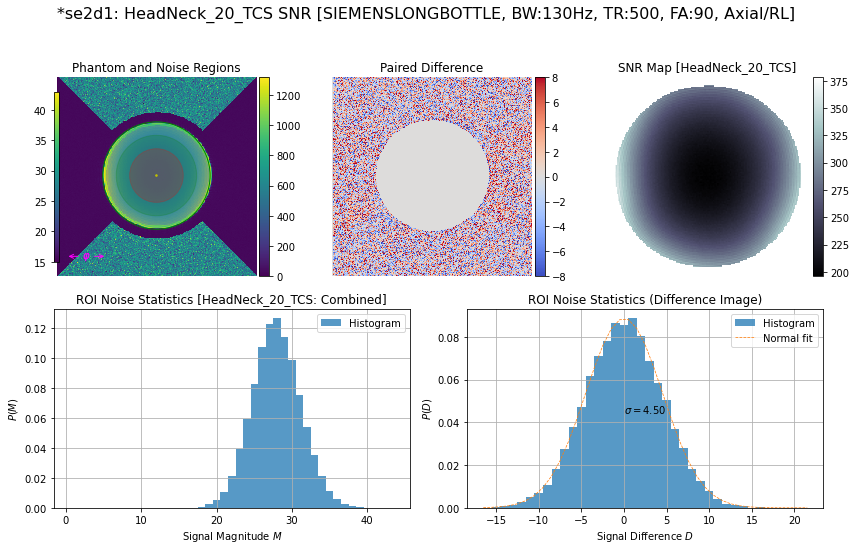

HeadNeck_20_TCS
RegionSize                 
0.50                  213.0
0.75                  233.0

In [20]:
# LONGBOTTLE: Signal to Noise
patid, stuid, series = itemgetter('PatID', 'StudyID', 'Series')(tests['QuarterlySNR'])

raw_tra = fetch_series(patid, stuid=studyid, sernos=series['Signal_Combined'], studydate='latest')
results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]])
plt.show()
with pd.option_context('display.precision', 2):
    display(np.round(results))

These results are rather lower than at acceptance. However, this is due to a change in protocol - the previous scans had been inadvertently subject to interpolation (and hence also smoothing). The values here should be taken as more representative.

In [21]:
NewPage

#### Single-element SNR
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

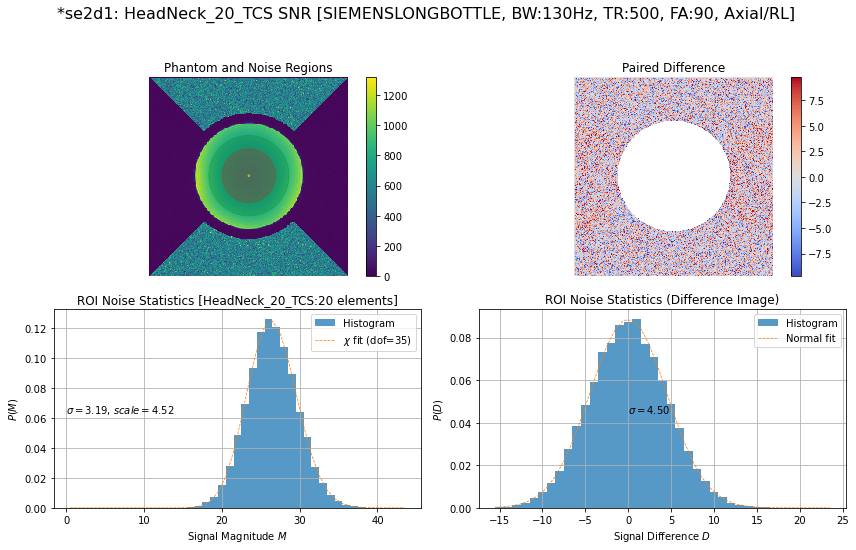

HeadNeck_20_TCS
0.50           213.11
0.75           232.90

In [22]:
# SNR (uncombined channels)
patid, stuid, series = itemgetter('PatID', 'StudyID', 'Series')(tests['QuarterlySNR'])
dobjs = sorted(
    fetch_series(patid, studyid, series['Signal'], studydate='latest'),
    key=lambda x: (series_number(x), acquisition_number(x), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

result = snr_report_multi(dobjsa, dobjsb, phantom=SIEMENSLONGBOTTLE)
plt.show()
with pd.option_context('display.precision', 2):
    display(result)

These results are rather lower than at acceptance and at the previous quarterly. However, this is due to a change in protocol - the previous scans had been inadvertently subject to interpolation (and hence also smoothing). The values here should be taken as more representative.

In [23]:
NewPage

### Frequency Reference and Transmitter Voltage
These are the reference values reported in the DICOM header of the Localizer scan.

In [24]:
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series)[0]

df = pd.DataFrame({
    'SoftwareVersions': [software_versions(dobj)],
    'ImagingFrequency': [larmor_frequency(dobj)],
    'TransmitterCalibration': [transmitter_calibration(dobj)],
    'TalesReferencePower': [tales_reference_power(dobj)],
    'GradientSensitivityX': [
        float(gradient_sensitivities(dobj)[0]) * 1e6,
    ],
    'GradientSensitivityY': [
        float(gradient_sensitivities(dobj)[1]) * 1e6,
    ],
    'GradientSensitivityZ': [
        float(gradient_sensitivities(dobj)[2]) * 1e6,
    ]
}, index=['Value']).T
df

Value
SoftwareVersions        syngo MR XA31
ImagingFrequency               63.679
TransmitterCalibration         296.59
TalesReferencePower           1281.29
GradientSensitivityX            90.92
GradientSensitivityY           92.337
GradientSensitivityZ           93.559